In [1]:
"""# Execute this cell to install OpenMM in the Colab environment
!pip install -q condacolab
import condacolab
condacolab.install_mambaforge()
!mamba install openmm
# We also need to get a few files that the cookbook depends on
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/cookbook/villin.pdb'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/cookbook/ala_ala_ala.pdb'"""

"# Execute this cell to install OpenMM in the Colab environment\n!pip install -q condacolab\nimport condacolab\ncondacolab.install_mambaforge()\n!mamba install openmm\n# We also need to get a few files that the cookbook depends on\n!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/cookbook/villin.pdb'\n!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/cookbook/ala_ala_ala.pdb'"

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# topology
from openmm.app.topology import Topology
from openmm.app.element import Element
elem = Element(0, "X", "X", 1.0)
top = Topology()
top.addChain()
top.addResidue("xxx", top._chains[0])
top.addAtom("X", elem, top._chains[0]._residues[0])


<Atom 0 (X) of chain 0 residue 0 (xxx)>

C:\Users\13401\AppData\Local\Temp\ipykernel_21864\2394123202.py:76: RuntimeWarning: invalid value encountered in divide
  axes[int(i / 2), i % 2].plot(x[1:], simulation_dist / np.sum(simulation_dist))


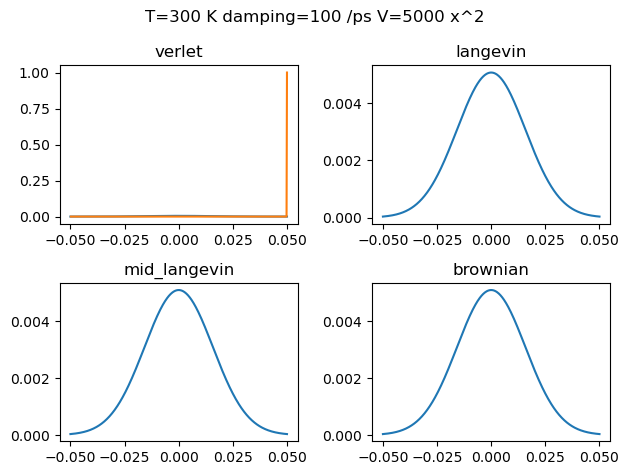

In [8]:
import openmm
from openmm import unit

# parameter setup
temperature = 300 * unit.kelvin
damping = 100 / unit.picosecond
timestep = 0.001 * unit.picosecond
steps = 10000
from openmm.unit import Quantity
from openmm import Vec3
start = Quantity(value=[Vec3(0.05, 0, 0)], unit=unit.nanometer)
x_force_constant_per_two = 5000     # unit kJ/mol/nm^2
mass = 12.0 * unit.amu

# potential setup

#get a parameter for time spent.
t_parameter = 

x_pot = openmm.CustomExternalForce(f"{x_force_constant_per_two} * ((x-x0)^2 + (y-y0)^2)")
x_pot.addGlobalParameter("x0", 1)
x_pot.addGlobalParameter("y0", 1)
#y_pot = openmm.CustomExternalForce("100000 * y^2") # very large force constant in y
z_pot = openmm.CustomExternalForce("100000 * z^2") # very large force constant in z
x_pot.addParticle(0)
#y_pot.addParticle(0)
z_pot.addParticle(0)

system = openmm.System()
system.addParticle(mass)
system.addForce(x_pot)
#system.addForce(y_pot)
system.addForce(z_pot)

# true potential representation
x = np.linspace(-0.05, 0.05, 500)
utotx = x_force_constant_per_two * x * x

# listing integrators
labels = [
    "verlet",
    # "Nose-Hoover",
    "langevin",
    # "var_langevin",
    "mid_langevin",
    "brownian"
]
integrators = [
    openmm.VerletIntegrator(timestep),
    # NoseHooverIntegrator(temperature, damping, timestep),
    openmm.LangevinIntegrator(temperature, damping, timestep),
    # VariableLangevinIntegrator(temperature, damping, timestep),
    openmm.LangevinMiddleIntegrator(temperature, damping, timestep),
    openmm.BrownianIntegrator(temperature, damping, timestep)
]

# preparing plots
f, axes = plt.subplots(nrows=round(len(integrators) / 2), ncols=2)
# calculating exact Boltzmann probability
prob = np.exp(-utotx / (temperature * 0.0083144621)) / np.sum(np.exp(-utotx / (temperature * 0.0083144621)))
for r in axes:
    for a in r:
        a.plot(x, prob)

# running simulations
for i in range(len(integrators)):
    from openmm.app import Simulation
    sim = Simulation(top, system, integrators[i])
    sim.context.setPositions(start)
    dat = np.empty(shape=(steps, 8))
    for j in range(steps):
        state = sim.context.getState(getVelocities=True, getPositions=True, getEnergy=True)
        dat[j, 0:3] = state.getPositions(asNumpy=True)[0]._value
        dat[j, 3:6] = state.getVelocities(asNumpy=True)[0]._value
        dat[j, 6] = state.getPotentialEnergy()._value
        dat[j, 7] = state.getKineticEnergy()._value
        sim.step(1)
    # creating probability of the simulation
    simulation_dist = np.histogram(dat[:, 0], x)[0]
    axes[int(i / 2), i % 2].plot(x[1:], simulation_dist / np.sum(simulation_dist))
    axes[int(i / 2), i % 2].title.set_text(labels[i])


f.suptitle(f"T={temperature} damping={damping} V={x_force_constant_per_two} x^2")
plt.tight_layout()
plt.show()

Text(0.5, 0, 'x')

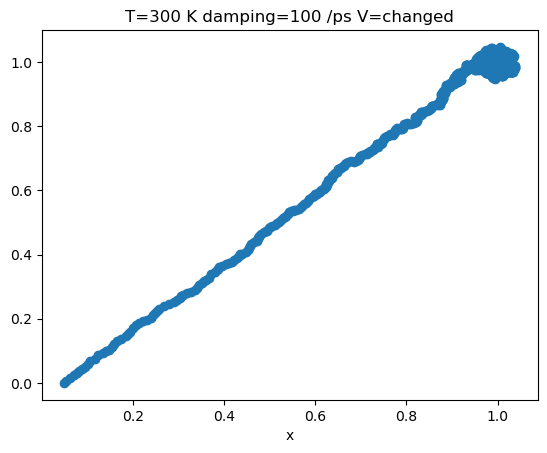

: 

In [9]:
#plot the distribution over x and y
#on a new plt.figure()
plt.figure()
plt.scatter(dat[:,0],dat[:,1])
plt.title(f"T={temperature} damping={damping} V=changed")
plt.xlabel("x")